<a href="https://colab.research.google.com/github/Mevan-V/Spider_Inductions/blob/main/ML1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedmaher5/vehicle-classification")

100%|██████████| 827M/827M [00:39<00:00, 21.7MB/s]

Extracting files...


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import os

def convert_time(s):
    h = s // 3600
    s = s %  3600
    m = s // 60
    s = s % 60
    return int(h), int(m), s

# Checkpoint Saving and Retrieving function

def save_checkpoint(model, optimizer, best_acc):
    checkpoint_dict = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_acc': best_acc
    }
    torch.save(checkpoint_dict, 'checkpoint.pth')

def retrieve_checkpoint(num_classes, device, phase = 'train'):
    if phase in ['train', 'eval']:
        checkpoint_dict = torch.load('checkpoint.pth', map_location = device)

        global model, optimizer, criterion, best_acc

        model = models.resnet18(weights = 'ResNet18_Weights.DEFAULT')
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        model.load_state_dict(checkpoint_dict['model_state_dict'])
        model.to(device)

        optimizer = torch.optim.SGD(model.parameters(), lr = 0, momentum = 0)
        optimizer.load_state_dict(checkpoint_dict['optimizer_state_dict'])

        criterion = nn.CrossEntropyLoss()

        best_acc = checkpoint_dict['best_acc']

        if phase == 'train':
            model.train()
        elif phase == 'eval':
            model.eval()
    else:
        print(f"warning! Expected the 'phase' argument; got wrong argument!")
        raise Exception

In [3]:
# Device Configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper Parameters

learning_rate = 0.001
num_epochs = 10
batch_size = 8
num_workers = 2
train_data_percentage = 0.73
valid_data_percentage = 0.12
momentum = 0.5

In [4]:
# Data Preparation

mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

data_dir = os.path.join(path, 'Vehicles')
image_datasets = datasets.ImageFolder(data_dir, transform)

# Dividing the Data

dataset_size = len(image_datasets)
train_size = math.ceil(train_data_percentage * dataset_size)
valid_size = math.ceil(valid_data_percentage * dataset_size)
test_size = dataset_size - (train_size + valid_size)
print(f"train size = {train_size}\nvalid size = {valid_size}\ntest size = {test_size}")

train_data, valid_data, test_data = random_split(image_datasets, [train_size, valid_size, test_size])

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = num_workers)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = False, num_workers = num_workers)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False, num_workers = num_workers)
print(f"train loader = {len(train_loader)} batches\nvalid loader = {len(valid_loader)} batches\ntest loader = {len(test_loader)} batches")

classes = image_datasets.classes
num_classes = len(classes)
print(f"Classes = {classes}")

train size = 4080
valid size = 671
test size = 838
train loader = 510 batches
valid loader = 84 batches
test loader = 105 batches
Classes = ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']


In [5]:
# Model

if not os.path.exists('checkpoint.pth'):
    model = models.resnet18(weights = 'ResNet18_Weights.DEFAULT')
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model.to(device)

    # Loss and Optimizer

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)

    save_checkpoint(model, optimizer, 0)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]


In [6]:
# Training Loop

if num_epochs >= 1:
    retrieve_checkpoint(num_classes, device, 'train')

num_total_steps = len(train_loader)
since = time.time()

for epoch in range(num_epochs):
    for images, labels in train_loader:

        # Device Shifting

        images = images.to(device)
        labels = labels.to(device)

        # Forward Pass

        outputs = model(images)
        # _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward Pass

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation

    n_correct = 0

    for images, labels in valid_loader:

        # Device Shifting

        images = images.to(device)
        labels = labels.to(device)

        # Forward Pass

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        n_correct += (preds == labels).sum().item()

        # Accuracy

        acc = 100 * n_correct / valid_size

        if acc > best_acc:
            best_acc = acc
            save_checkpoint(model, optimizer, best_acc)

    print(f"epoch = {epoch + 1}/{num_epochs}, loss = {loss.item():.4f}")
hrs, mins, secs = convert_time(time.time() - since)
print(f"Training Complete! Time elapsed = {hrs} h {mins} m {int(secs)} s")

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch = 1/10, loss = 0.1196


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch = 2/10, loss = 0.0440


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch = 3/10, loss = 0.2828


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch = 4/10, loss = 0.0039


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch = 5/10, loss = 0.1037


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch = 6/10, loss = 0.0706


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch = 7/10, loss = 0.0585


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch = 8/10, loss = 0.0060


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch = 9/10, loss = 0.1427


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch = 10/10, loss = 0.0070
Training Complete! Time elapsed = 0 h 10 m 40 s


In [7]:
# Testing

retrieve_checkpoint(num_classes, device, 'eval')

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(num_classes)]
    n_class_samples = [0 for i in range(num_classes)]
    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        num_images = len(images)
        n_correct += (preds == labels).sum().item()
        n_samples += num_images

        for i in range(num_images):
            pred = preds[i]
            label = labels[i]
            if (pred == label):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    print(f"Class correct = {n_class_correct}\nClass samples = {n_class_samples}\n")
    print(f"Best Validation Accuracy = {best_acc:.2f}%")
    acc = 100 * n_correct / n_samples
    print(f"Accuracy of test set = {acc:.2f}%\n")

    for i in range(num_classes):
        acc = 100 * n_class_correct[i] / n_class_samples[i]
        print(f"Accuracy of {classes[i]} = {acc:.2f}%")

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Class correct = [103, 136, 129, 125, 107, 106, 123]
Class samples = [105, 136, 132, 127, 108, 106, 124]

Best Validation Accuracy = 97.02%
Accuracy of test set = 98.93%

Accuracy of Auto Rickshaws = 98.10%
Accuracy of Bikes = 100.00%
Accuracy of Cars = 97.73%
Accuracy of Motorcycles = 98.43%
Accuracy of Planes = 99.07%
Accuracy of Ships = 100.00%
Accuracy of Trains = 99.19%


In [8]:
# Final Instruction

## Get an image from every class, run the prediction and the display the results using matplotlib

retrieve_checkpoint(num_classes, device, 'eval')

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(num_classes)]
    n_class_samples = [0 for i in range(num_classes)]
    n_class_loss = [0 for i in range(num_classes)]
    n_class_softmax = [0 for i in range(num_classes)]
    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        softmax = F.softmax(outputs, dim = 1)

        num_images = len(images)

        for i in range(num_images):
            pred = preds[i]
            label = labels[i]
            loss = criterion(outputs[i].unsqueeze(0), label.unsqueeze(0))
            if n_class_samples[label] == 0:     # Only allows the first image of every class
                if (pred == label):             # of the test data loader to be predicted
                    n_class_correct[label] += 1
                n_class_samples[label] += 1
                n_class_loss[label] = loss.item()
                n_class_softmax[label] = softmax[i].tolist()
    print("----- Classes are corresponding to indices -----\n")
    print(f"Predicted Labels = {n_class_correct}\n")
    print("The predicted softmax values for each class:")
    n_class_softmax = np.array(n_class_softmax)
    n_class_softmax = np.round(n_class_softmax, 8)
    n_class_softmax = n_class_softmax.tolist()
    for i in range(num_classes):
        print(f"\t{classes[i]} = {n_class_softmax[i]}")

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


----- Classes are corresponding to indices -----

Predicted Labels = [1, 1, 1, 1, 1, 1, 1]

The predicted softmax values for each class:
	Auto Rickshaws = [0.99982822, 7.37e-06, 0.00013714, 7.02e-06, 2.19e-06, 5.16e-06, 1.298e-05]
	Bikes = [2.08e-06, 0.99995542, 1.45e-06, 2.57e-06, 2.153e-05, 8.15e-06, 8.78e-06]
	Cars = [2.32e-06, 5.79e-06, 0.99990118, 6.318e-05, 7.06e-06, 5.7e-06, 1.483e-05]
	Motorcycles = [7.641e-05, 0.00015991, 9.33e-06, 0.99970275, 2.67e-05, 4.2e-06, 2.072e-05]
	Planes = [5.459e-05, 3.027e-05, 8.19e-06, 7.055e-05, 0.9989323, 0.00059288, 0.00031137]
	Ships = [1.773e-05, 9.9e-06, 2.987e-05, 1.211e-05, 0.00050996, 0.99939489, 2.546e-05]
	Trains = [0.00090078, 0.00018896, 6.742e-05, 3.282e-05, 4.679e-05, 0.00071511, 0.99804807]


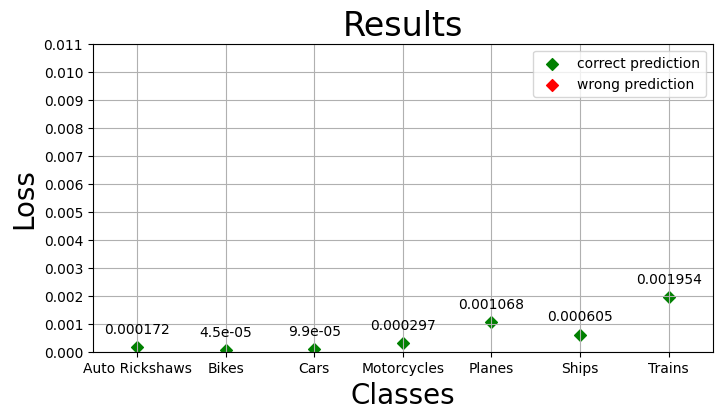

In [9]:
# Plot
x = [i for i in range(num_classes)]
y = n_class_loss
x_labels = classes

plt.rcParams.update({
    'axes.labelsize': 20,
    'axes.titlesize': 24
})

plt.figure(figsize =(8, 4))
plt.title('Results')
for i in range(num_classes):
    if n_class_correct[i]:
        plt.scatter(x[i], y[i], marker = 'D', color = 'green')
    else:
        plt.scatter(x[i], y[i], marker = 'D', color = 'green')
    plt.annotate(str(round(y[i], 6)), (x[i], y[i]), textcoords = 'offset points', xytext = (0, 10), ha = 'center')
plt.scatter(100, 100, marker = 'D', color = 'green', label = 'correct prediction')
plt.scatter(100, 100, marker = 'D', color = 'red', label = 'wrong prediction')
plt.xlim(0-0.5, 6+0.5)
plt.ylim(0, 0.011)
plt.xticks(ticks = x, labels = x_labels)
plt.yticks(np.arange(0, 0.011 + 0.001, 0.001))
plt.ylabel('Loss')
plt.xlabel('Classes')
plt.grid()
plt.legend()
plt.show()